In [1]:
import pandas as pd

yelp_data_path = '/home/dai/33/nlp_cv/data/sentiment+labelled+sentences/sentiment labelled sentences/yelp_labelled.txt'

df = pd.read_csv(yelp_data_path, names=['text', 'label'], sep='\t')
df.head()

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [2]:
from sklearn.model_selection import train_test_split

X = df['text'].values
y = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=1000)

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [4]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

2024-01-02 23:36:39.273820: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 23:36:39.323560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 23:36:39.323593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 23:36:39.324608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 23:36:39.332698: I tensorflow/core/platform/cpu_feature_guar

In [5]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Simple RNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           17470     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               17792     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 36563 (142.82 KB)
Trainable params: 36563 (142.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
75/75 [==============================] - 4s 37ms/step - loss: 0.7191 - accuracy: 0.4933 - val_loss: 0.7030 - val_accuracy: 0.4880
Epoc

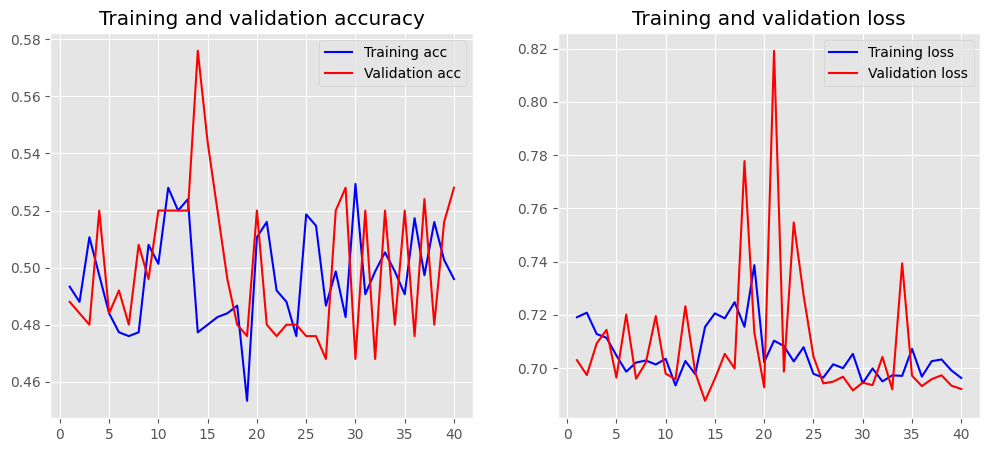

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding

embedding_dim = 10

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(SimpleRNN(128))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1,
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

In [14]:
text1 = 'Best Service ever! It was great, I will definitely recommend it.'
text2 = 'Very, very sad.'
text3 = 'Amazing... great place.'

def predict_review_phind(review):
   # Preprocess the review
   sequence = tokenizer.texts_to_sequences([review])
   sequence = pad_sequences(sequence, maxlen=maxlen)

   # Get the prediction
   prediction = model.predict(sequence, verbose=0)[0][0]

   # Return the result
   if prediction > 0.5:
       return (prediction, "Positive")
   else:
       return (prediction, "Negative")


predict_review_phind(text2)

(0.5025064, 'Positive')

### LSTM Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           17470     
                                                                 
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 88767 (346.75 KB)
Trainable params: 88767 (346.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
75/75 [==============================] - 7s 69ms/step - loss: 0.6943 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.4800
Epoch 2/40
75/75 [==============================] - 5s 62ms/step - loss: 0.6935 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.

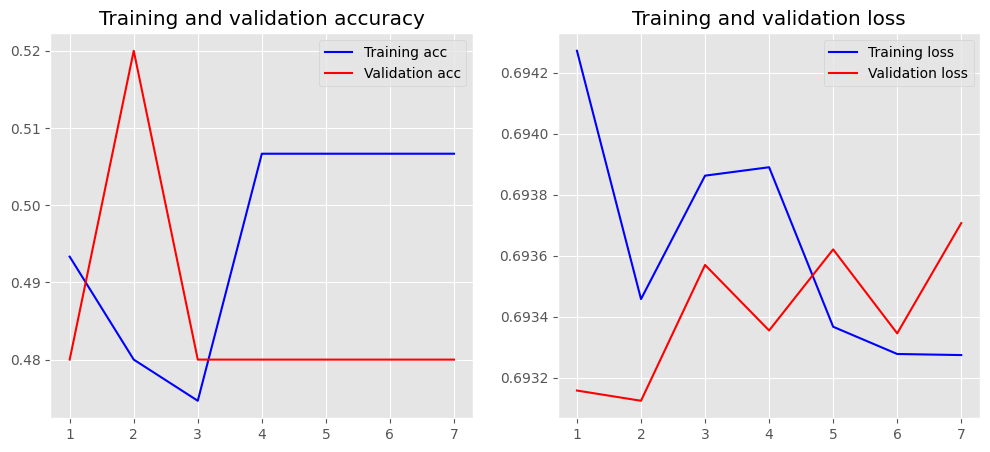

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping

embedding_dim = 10

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=40,
                    verbose=1,
                    batch_size=10,
                    callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

In [11]:
text1 = 'Best Service ever! It was great, I will definitely recommend it.'
text2 = 'Very, very sad.'
text3 = 'Amazing... great place.'

def predict_review_phind(review):
   # Preprocess the review
   sequence = tokenizer.texts_to_sequences([review])
   sequence = pad_sequences(sequence, maxlen=maxlen)

   # Get the prediction
   prediction = model.predict(sequence, verbose=0)[0][0]

   # Return the result
   if prediction > 0.5:
       return (prediction, "Positive")
   else:
       return (prediction, "Negative")


predict_review_phind(text3)

(0.49568263, 'Negative')

### Bidirectional LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           17470     
                                                                 
 bidirectional (Bidirection  (None, 256)               142336    
 al)                                                             
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 162387 (634.32 KB)
Trainable params: 162387 (634.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
75/75 [==============================] - 9s 71ms/step - loss: 0.69

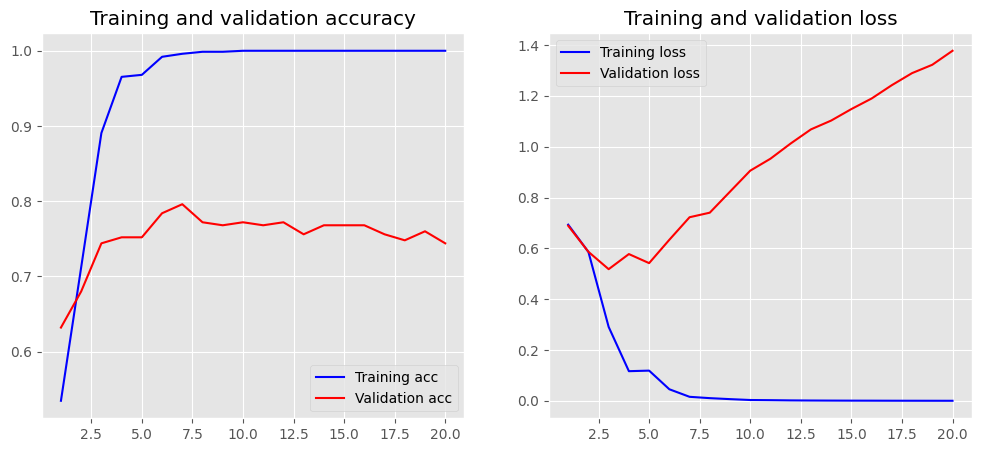

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras.callbacks import EarlyStopping

embedding_dim = 10

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1,
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

In [10]:
text1 = 'Best Service ever! It was great, I will definitely recommend it.'
text2 = 'Very, very sad.'
text3 = 'Amazing... great place.'

def predict_review_phind(review):
   # Preprocess the review
   sequence = tokenizer.texts_to_sequences([review])
   sequence = pad_sequences(sequence, maxlen=maxlen)

   # Get the prediction
   prediction = model.predict(sequence, verbose=0)[0][0]

   # Return the result
   if prediction > 0.5:
       return (prediction, "Positive")
   else:
       return (prediction, "Negative")


predict_review_phind(text3)

(0.039593212, 'Negative')

### GRU

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           17470     
                                                                 
 gru (GRU)                   (None, 64)                14592     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 32723 (127.82 KB)
Trainable params: 32723 (127.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
75/75 [==============================] - 6s 57ms/step - loss: 0.6933 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.4800
Epoc

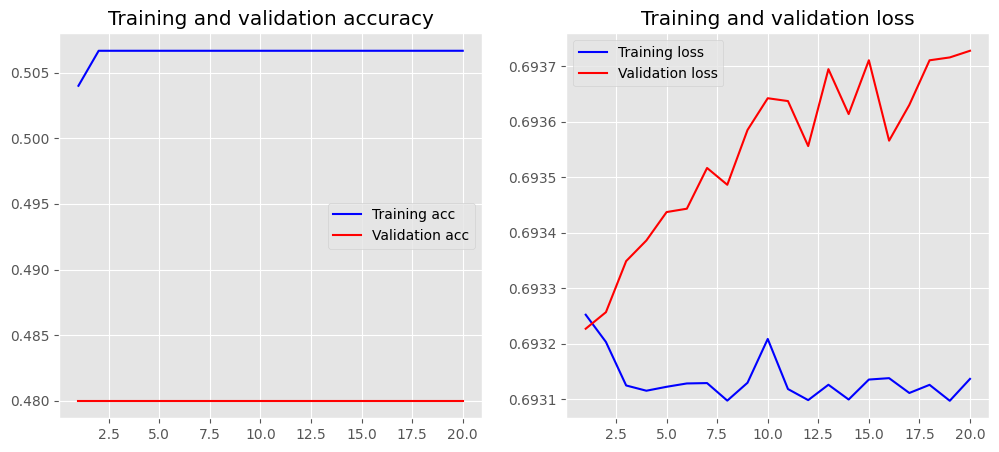

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, Bidirectional
from keras.callbacks import EarlyStopping

embedding_dim = 10

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(GRU(64))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1,
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

In [9]:
text1 = 'Best Service ever! It was great, I will definitely recommend it.'
text2 = 'Very, very sad.'
text3 = 'Amazing... great place.'

def predict_review_phind(review):
   # Preprocess the review
   sequence = tokenizer.texts_to_sequences([review])
   sequence = pad_sequences(sequence, maxlen=maxlen)

   # Get the prediction
   prediction = model.predict(sequence, verbose=0)[0][0]

   # Return the result
   if prediction > 0.5:
       return (prediction, "Positive")
   else:
       return (prediction, "Negative")


predict_review_phind(text2)

(0.49372476, 'Negative')

### Bidirectional GRU

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           17470     
                                                                 
 bidirectional (Bidirection  (None, 128)               29184     
 al)                                                             
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 47955 (187.32 KB)
Trainable params: 47955 (187.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
75/75 [==============================] - 7s 57ms/step - loss: 0.6938

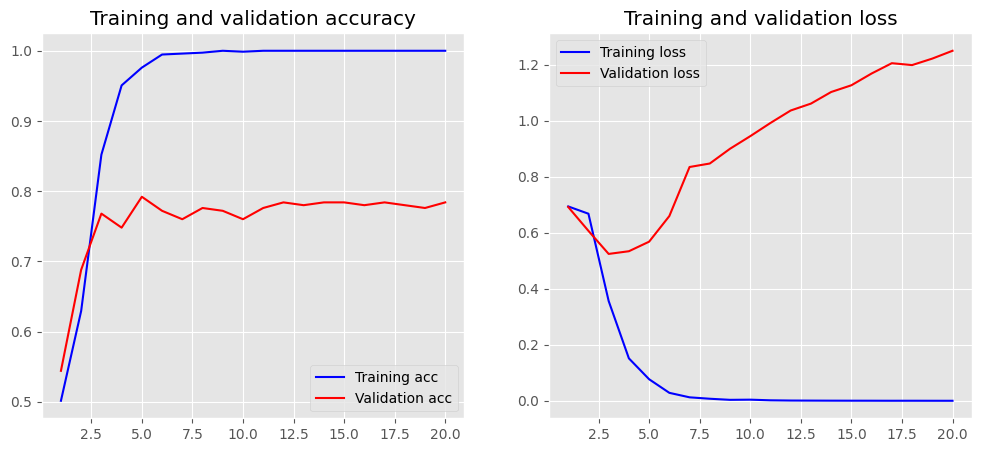

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, Bidirectional
from keras.callbacks import EarlyStopping

embedding_dim = 10

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(GRU(64)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1,
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

In [10]:
text1 = 'Best Service ever! It was great, I will definitely recommend it.'
text2 = 'Very, very sad.'
text3 = 'Amazing... great place.'

def predict_review_phind(review):
   # Preprocess the review
   sequence = tokenizer.texts_to_sequences([review])
   sequence = pad_sequences(sequence, maxlen=maxlen)

   # Get the prediction
   prediction = model.predict(sequence, verbose=0)[0][0]

   # Return the result
   if prediction > 0.5:
       return (prediction, "Positive")
   else:
       return (prediction, "Negative")


predict_review_phind(text3)

(0.8118255, 'Positive')